# Classifier model

This notebook deals with finding a classifier model to classify a given image into a correct class. Therefor I will evaluate different approaches.

## Setup and general preparation


In [2]:
# Imports
import import_ipynb

from sklearn.metrics import classification_report, confusion_matrix
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchsummary import summary
from utils import DEVICE, classes, train_data, test_data, BaseModule # type: ignore
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
# Global variables

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
PATIENCE = 5

# Data loaders
TRAIN_LOADER = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=6)
TEST_LOADER = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

# Loss functions
CRITERION = nn.CrossEntropyLoss() # CrossEntropyLoss combines log-softmax + NLLLoss

# LR scheduler lambda function
def lr_lambda(epoch):
    return 0.95 ** (epoch - 1)

### Training, Validation and Evaluation Workflow

In order to compare different models to each other faster, I wrote central train, test and evaluation functions. This way I'm able to just create a bunch of different models and compare them easily. 

For evaluation I choose the following metrics:

| Metric               | Formula                               | Description                                                                                    | 
|----------------------|---------------------------------------|------------------------------------------------------------------------------------------------|
| `Accuracy`           | Overall correct predictions} / total  | How well the model performs in general.                                                        |
| `Precision`          | TP / (TP + FP)                        | How many of the images predicted to be in a class are actually that class.                     |
| `Recall`             | TP / (TP + FN)                        | How many of the images in a class did the model classify correctly.                            |
| `F1-score`           | Harmonic mean of precision and recall | Balances precision and recall, shows how well the model doing on each class overall            |                  
| `Confusion Matrix`   | -                                     | Shows precisely what image as been classified as which class in comparison to the ground truth |

By employing other metrics than just the accuracy I'm able to get a more detailed and classwise view of model. Even though the classes are balanced maybe the model can't distinguish between to particular classes. This could then fixed by penalizing the false classifications more, or oversampling these images with some additional transforms.


In [5]:
# One Epoch train function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for data, targets in dataloader:
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        logits = model(data)

        # We use CrossEntropyLoss which combines softmax and NLLLoss
        loss = criterion(logits, targets)

        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * data.size(0)

        # Calculate accuracy
        _, preds = logits.max(1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# One Epoch test function
def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            logits = model(data)
            loss = criterion(logits, targets)

            running_loss += loss.item() * data.size(0)
            _, preds = logits.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_loss = running_loss / total
    accuracy = correct / total

    # Generate classification report, which includes precision, recall, and F1-score -> take the macro averaged ones
    report = classification_report(all_targets, all_preds, zero_division=0.0, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_targets

# Training loop for one model
def run_training_for_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=10,
    model_name='model',
    save_best=False
):
    # Save the metrics history for plotting later
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'test_prec': [],
        'test_rec': [],
        'test_f1': [],
        'test_preds': [],
        'test_targets': []
    }

    # Params for early stopping
    best_test_loss = float('inf')
    epochs_no_improve = 0

    best_test_acc = float('inf')

    print(f"Start training {model_name}")

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_targets = test(model, test_loader, criterion, device)

        # Early stopping logic
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if save_best and test_acc < best_test_acc:
            test_acc = best_test_acc
            torch.save(model, f'../weights/classifier/{model_name}.pt')

        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1} for model {model_name}")
            break

        scheduler.step()

        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['test_prec'].append(test_prec)
        history['test_rec'].append(test_rec)
        history['test_f1'].append(test_f1)
        history['test_preds'].append(test_preds)
        history['test_targets'].append(test_targets)

        print(f"Epoch {epoch+1} | Learning Rate {optimizer.param_groups[0]['lr']:.4f}\n"
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}")

    print(f"Training model {model_name} complete!")

    # Return history for evaluation and plotting
    return history

# Plotting metric history for all models
def plot_training_history(results):

    # Use a different color cycle for each model
    colors = plt.colormaps['tab10'].colors
    line_styles = ['-', '--', '-.', ':']
    color_cycle = itertools.cycle(colors)
    style_cycle = itertools.cycle(line_styles)

    num_models = len(results)
    model_names = list(results.keys())

    # Reset for consistent color/style per model
    model_styles = {}
    for name in model_names:
        model_styles[name] = {
            "color": next(color_cycle),
            "style": next(style_cycle)
        }

    # Create plot grid: 4 rows x 2 columns
    _, axs = plt.subplots(4, 2, figsize=(16, 20))
    axs = axs.flatten()

    # Metrics and their subplot indices
    metric_info = {
        'train_loss': (0, 'Training Loss'),
        'train_acc': (1, 'Training Accuracy'),
        'test_loss': (2, 'Test Loss'),
        'test_acc': (3, 'Test Accuracy'),
        'test_prec': (4, 'Test Precision'),
        'test_rec': (5, 'Test Recall'),
        'test_f1': (6, 'Test F1 Score'),
    }

    for metric, (idx, title) in metric_info.items():
        ax = axs[idx]
        for name, history in results.items():
            color = model_styles[name]["color"]
            style = model_styles[name]["style"]
            ax.plot(history[metric], label=name, color=color, linestyle=style)

        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.grid(True)
        ax.legend()

    # Hide the unused 8th subplot
    axs[7].axis('off')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results, index=-1, columns=2):
    n = len(results)
    rows = (n + columns - 1) // columns  # Ceiling division

    class_labels = [classes[i] for i in sorted(classes.keys())]

    _, axs = plt.subplots(rows, columns, figsize=(columns * 6, rows * 5))
    axs = axs.flatten()

    for i, (name, history) in enumerate(results.items()):
        cm = confusion_matrix(history['test_targets'][index], history['test_preds'][index])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels,
                    ax=axs[i])
        axs[i].set_title(f'{name}')
        axs[i].set_xlabel('Predicted')
        axs[i].set_ylabel('True')

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# Main evaluation function to run the training and evaluation
def evaluate_models(models):
    results = {name: None for name in models.keys()}

    for name, model in models.items():
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

        history = run_training_for_model(
            model=model,
            train_loader=TRAIN_LOADER,
            test_loader=TEST_LOADER,
            criterion=CRITERION,
            optimizer=optimizer,
            scheduler=scheduler,
            device=DEVICE,
            num_epochs=NUM_EPOCHS,
            model_name=name
        )

        results[name] = history

    return results

# Helper function to print model summary
def print_model_summary(models_dict):
    for model in models_dict.values():
        summary(model, input_size=(1, 28, 28))


### CNN

Since the dataset is very similar to the MNIST dataset I first want to explore training a CNN from scratch to get a baseline for the performance.

Moreover I found this kaggle notebook that evaluated some choices regarding the CNN architecture. In the following I will try to replicate these experiments on this dataset.

Reference:
 - [Kaggle Notebook](https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist)

#### Test 1: Amount of Convolution + Pooling Layers

Based on the referenced notebook I want to check how many of convolutional + pooling layer combinations produce the best output. 

- 1 Layer: 28 x 28 -> 14 x 14
- 2 Layers: 28 x 28 -> 14 x 14 -> 7 x 7
- 3 Layers: 28 x 28 -> 14 x 14 -> 7 x 7 -> 3 x 3

In [4]:
# Build the three CNN models
nets = 3
cnn_conv_layer_models = {f'CNN_{n + 1}_Conv': BaseModule() for n in range(nets)}

for i, model in enumerate(cnn_conv_layer_models.values()):

    # First Convolutional Layer (in every model)
    model.layers.append(nn.Conv2d(1, 24, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    if i > 0:
        # Second Convolutional Layer (in every model except the first)
        model.layers.append(nn.Conv2d(24, 48, kernel_size=5, padding='same'))
        model.layers.append(nn.LeakyReLU())
        model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        # Third Convolutional Layer (only in the third model)
        if i == 2:
            model.layers.append(nn.Conv2d(48, 64, kernel_size=5, padding='same'))
            model.layers.append(nn.LeakyReLU())
            model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    # Output sizes after convolutional layers
    # 28x28 -> 14x14 -> 7x7 -> 3x3
    # 24*14*14 -> 48*7*7 -> 64*3*3
    conv_out = [24*14*14, 48*7*7, 64*3*3]

    model.layers.append(nn.Flatten())
    model.layers.append(nn.Linear(conv_out[i], 256))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.Linear(256, 5))

    model.to(DEVICE)

print_model_summary(cnn_conv_layer_models)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]             624
         LeakyReLU-2           [-1, 24, 28, 28]               0
         MaxPool2d-3           [-1, 24, 14, 14]               0
           Flatten-4                 [-1, 4704]               0
            Linear-5                  [-1, 256]       1,204,480
         LeakyReLU-6                  [-1, 256]               0
            Linear-7                    [-1, 5]           1,285
Total params: 1,206,389
Trainable params: 1,206,389
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 4.60
Estimated Total Size (MB): 4.97
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Ou

In [5]:
# Evaluate the number of convolutional layers
cnn_conv_layer_models_results = evaluate_models(cnn_conv_layer_models)

Start training CNN_1_Conv
Epoch 1 | Learning Rate 0.0010
Train Loss: 0.4965 | Train Acc: 0.8316 | Test Acc: 0.9129 | Test F1: 0.9131
Epoch 2 | Learning Rate 0.0009
Train Loss: 0.3062 | Train Acc: 0.8992 | Test Acc: 0.9290 | Test F1: 0.9291
Epoch 3 | Learning Rate 0.0009
Train Loss: 0.2579 | Train Acc: 0.9154 | Test Acc: 0.9343 | Test F1: 0.9342
Epoch 4 | Learning Rate 0.0009
Train Loss: 0.2318 | Train Acc: 0.9234 | Test Acc: 0.9370 | Test F1: 0.9371
Epoch 5 | Learning Rate 0.0008
Train Loss: 0.2155 | Train Acc: 0.9287 | Test Acc: 0.9438 | Test F1: 0.9437
Epoch 6 | Learning Rate 0.0008
Train Loss: 0.2051 | Train Acc: 0.9320 | Test Acc: 0.9464 | Test F1: 0.9465
Epoch 7 | Learning Rate 0.0007
Train Loss: 0.1913 | Train Acc: 0.9368 | Test Acc: 0.9440 | Test F1: 0.9440
Epoch 8 | Learning Rate 0.0007
Train Loss: 0.1850 | Train Acc: 0.9380 | Test Acc: 0.9489 | Test F1: 0.9489
Epoch 9 | Learning Rate 0.0007
Train Loss: 0.1791 | Train Acc: 0.9401 | Test Acc: 0.9490 | Test F1: 0.9490
Epoch 10 | 

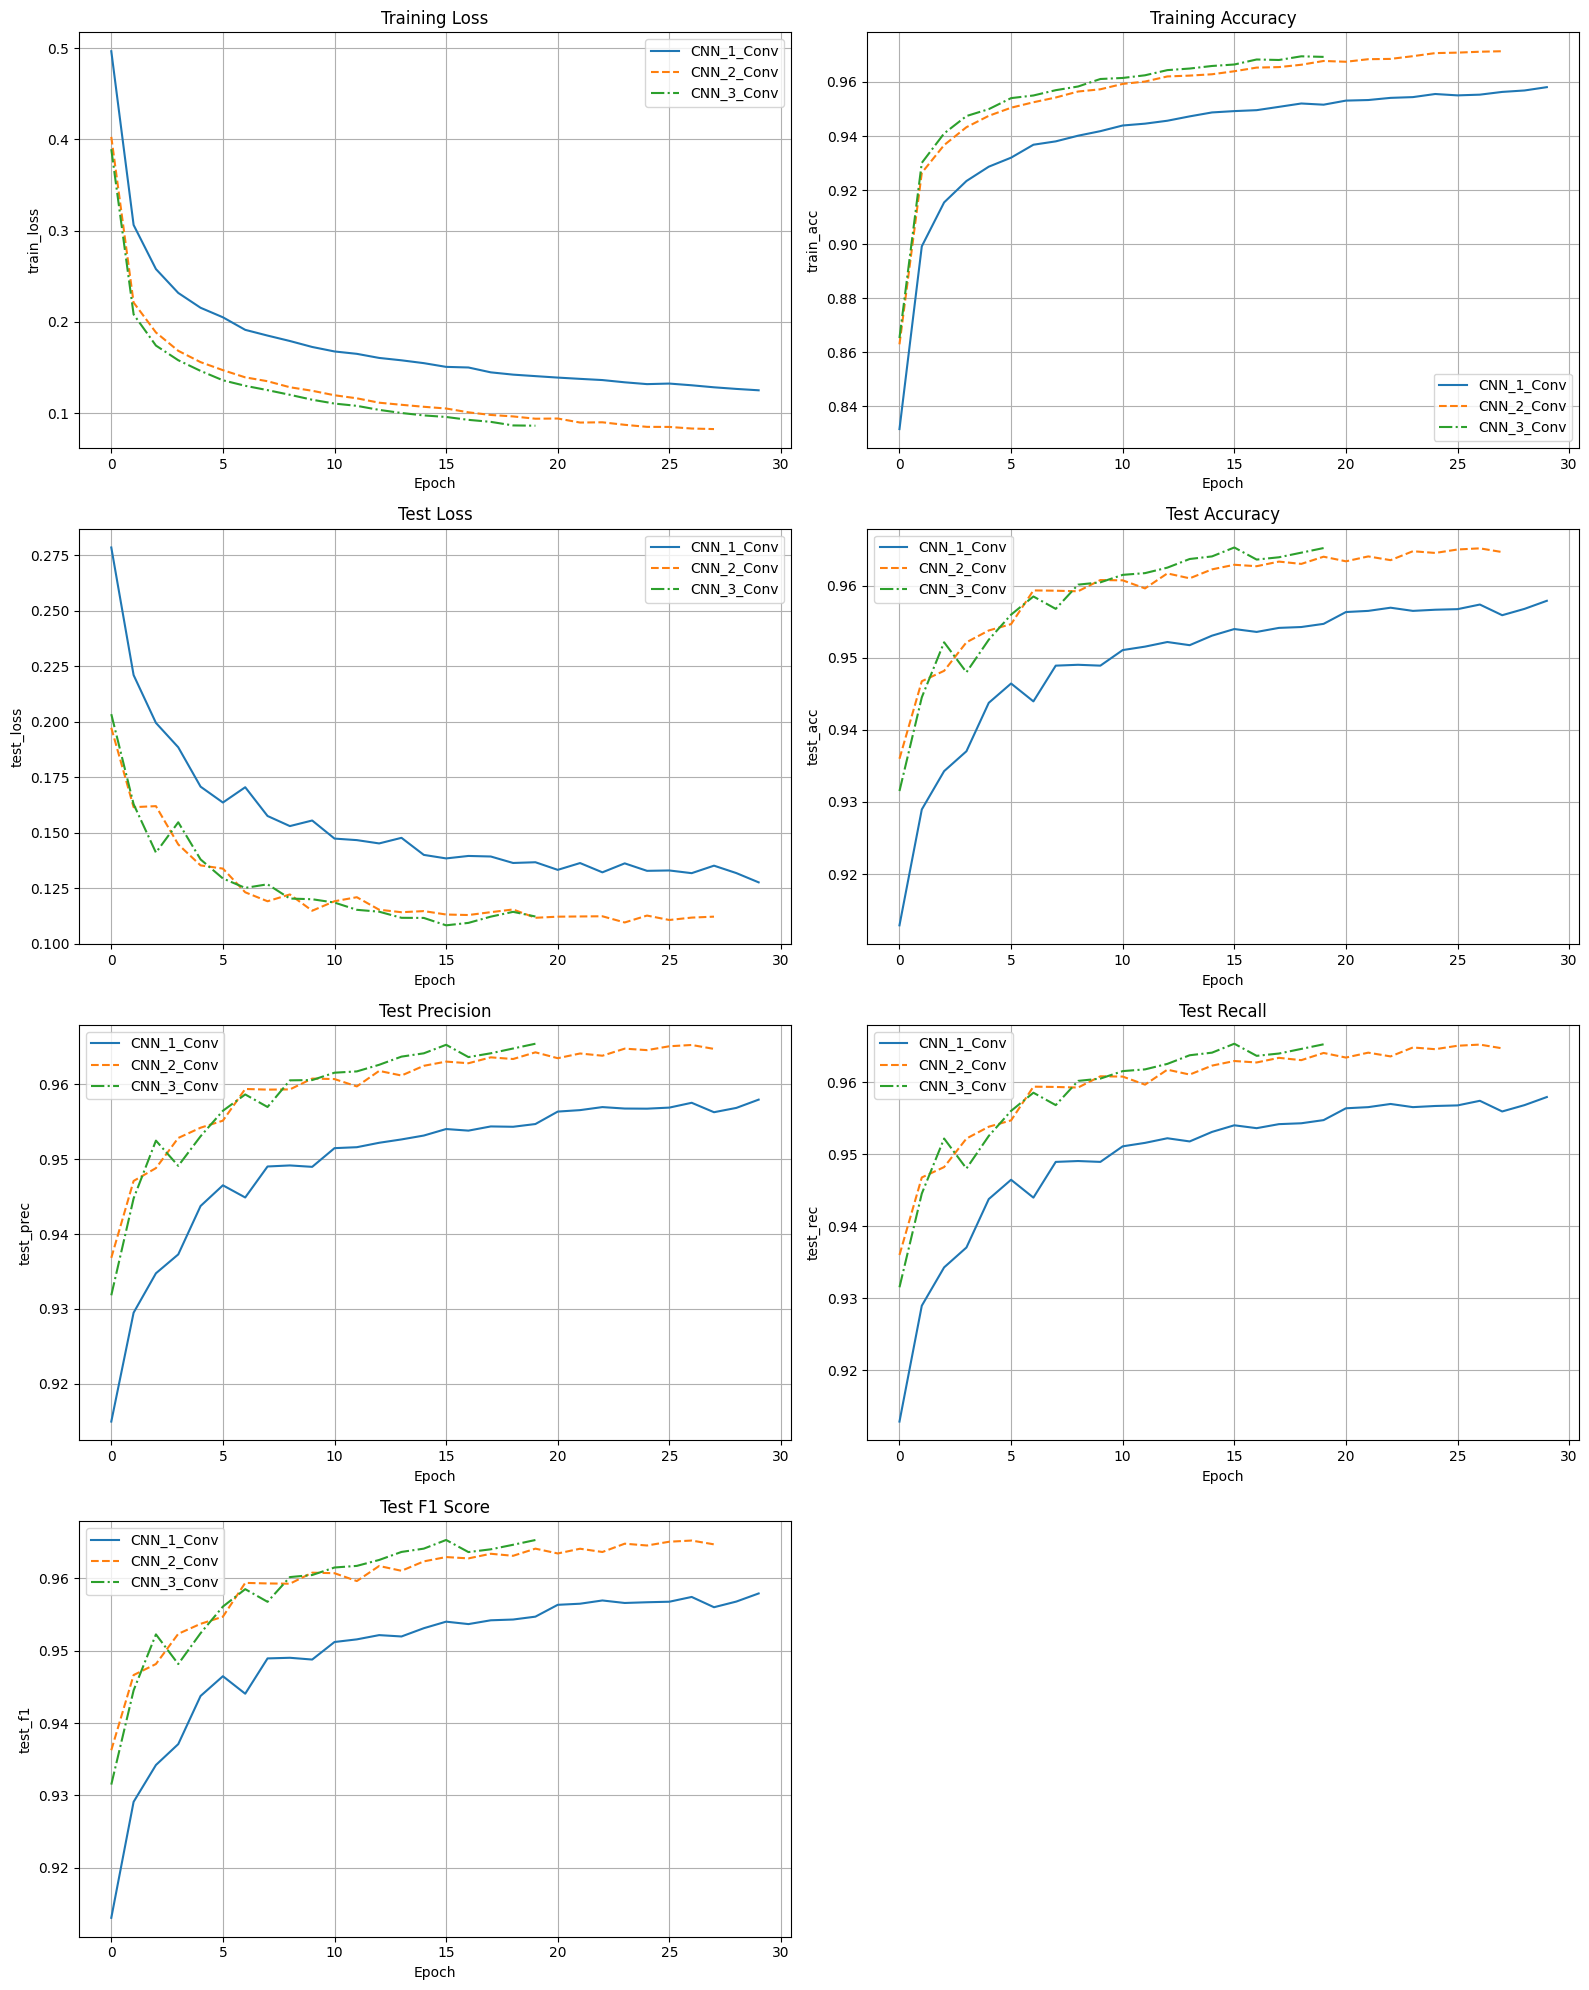

In [6]:
# Plot training
plot_training_history(cnn_conv_layer_models_results)

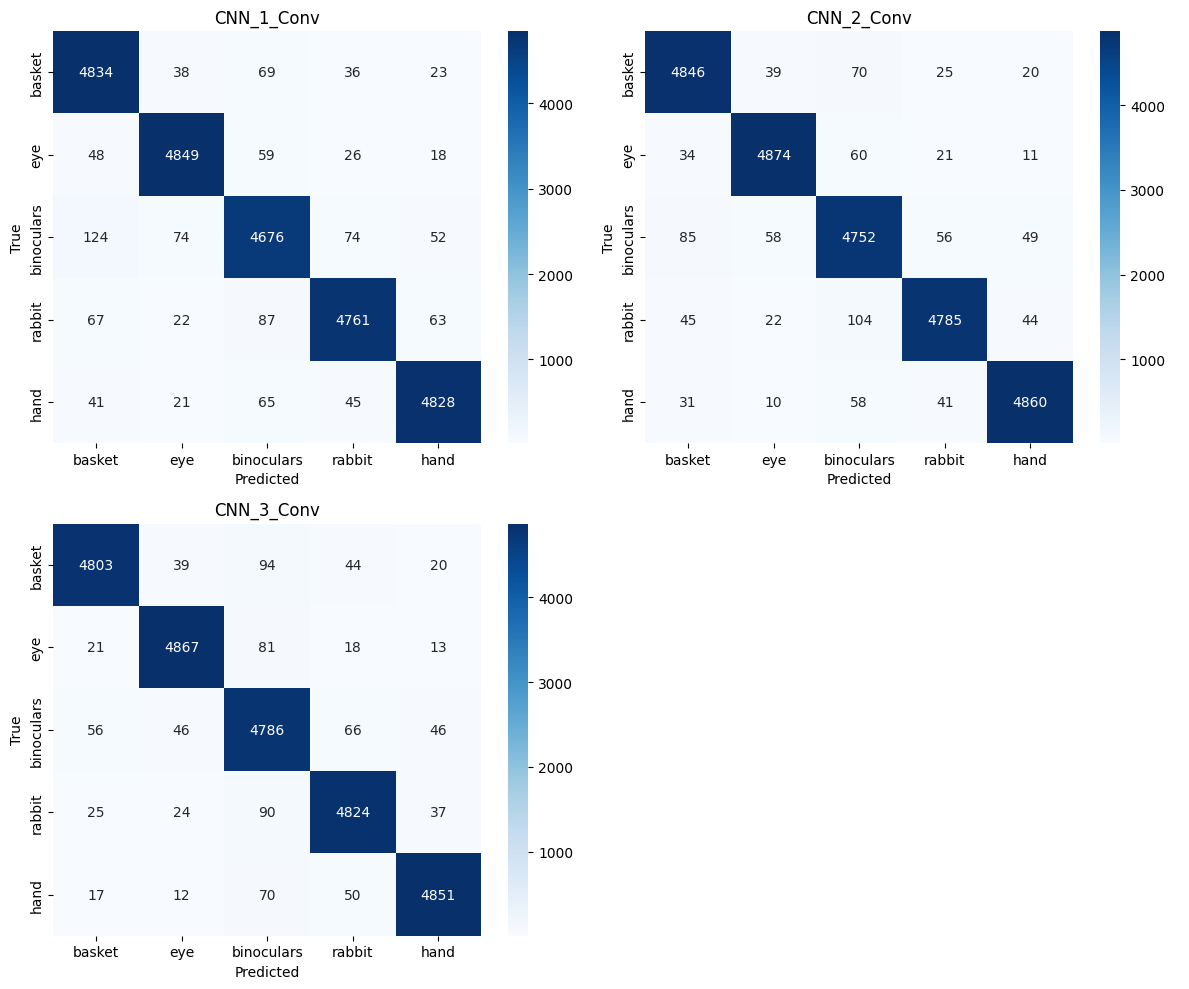

In [7]:
# Plot confusion matrices
plot_confusion_matrices(cnn_conv_layer_models_results)

##### Results:

2 Convolutional + Pooling Layers perform considerably better than 1. However three layers are only marginally better despite having more parameters in the convolutional parts of the network. 

So I will choose 2 Convolutional + Pooling Layers for my classifier.



#### Test 2: Amount of kernels

Now I want to determine how many kernels provide the best ratio between accuracy and model size.

- 8 + 16 Kernels
- 16 + 32 Kernels
- 24 + 48 Kernels
- 32 + 64 Kernels
- 40 + 80 Kernels
- 48 + 96 Kernels

In [8]:
nets = 6

cnn_num_kernels_models = {f'CNN_{n*8+8}_{n*16+16}_Kernels': BaseModule() for n in range(nets)}

for i, model in enumerate(cnn_num_kernels_models.values()):
    model.layers.append(nn.Conv2d(1, i*8+8, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Conv2d(i*8+8, i*16+16, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Flatten())
    model.layers.append(nn.Linear((i*16+16)*7*7, 256))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.Linear(256, 5))

    model.to(DEVICE)

print_model_summary(cnn_num_kernels_models)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             208
         LeakyReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           3,216
         LeakyReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
           Flatten-7                  [-1, 784]               0
            Linear-8                  [-1, 256]         200,960
         LeakyReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 5]           1,285
Total params: 205,669
Trainable params: 205,669
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.78
Estimated T

In [9]:
cnn_num_kernels_models_result = evaluate_models(cnn_num_kernels_models)

Start training CNN_8_16_Kernels
Epoch 1 | Learning Rate 0.0010
Train Loss: 0.4987 | Train Acc: 0.8300 | Test Acc: 0.9175 | Test F1: 0.9175
Epoch 2 | Learning Rate 0.0009
Train Loss: 0.2885 | Train Acc: 0.9049 | Test Acc: 0.9298 | Test F1: 0.9299
Epoch 3 | Learning Rate 0.0009
Train Loss: 0.2403 | Train Acc: 0.9211 | Test Acc: 0.9355 | Test F1: 0.9355
Epoch 4 | Learning Rate 0.0009
Train Loss: 0.2182 | Train Acc: 0.9281 | Test Acc: 0.9397 | Test F1: 0.9396
Epoch 5 | Learning Rate 0.0008
Train Loss: 0.2028 | Train Acc: 0.9334 | Test Acc: 0.9430 | Test F1: 0.9430
Epoch 6 | Learning Rate 0.0008
Train Loss: 0.1914 | Train Acc: 0.9350 | Test Acc: 0.9482 | Test F1: 0.9483
Epoch 7 | Learning Rate 0.0007
Train Loss: 0.1813 | Train Acc: 0.9387 | Test Acc: 0.9488 | Test F1: 0.9489
Epoch 8 | Learning Rate 0.0007
Train Loss: 0.1747 | Train Acc: 0.9413 | Test Acc: 0.9492 | Test F1: 0.9494
Epoch 9 | Learning Rate 0.0007
Train Loss: 0.1673 | Train Acc: 0.9436 | Test Acc: 0.9504 | Test F1: 0.9504
Epoch

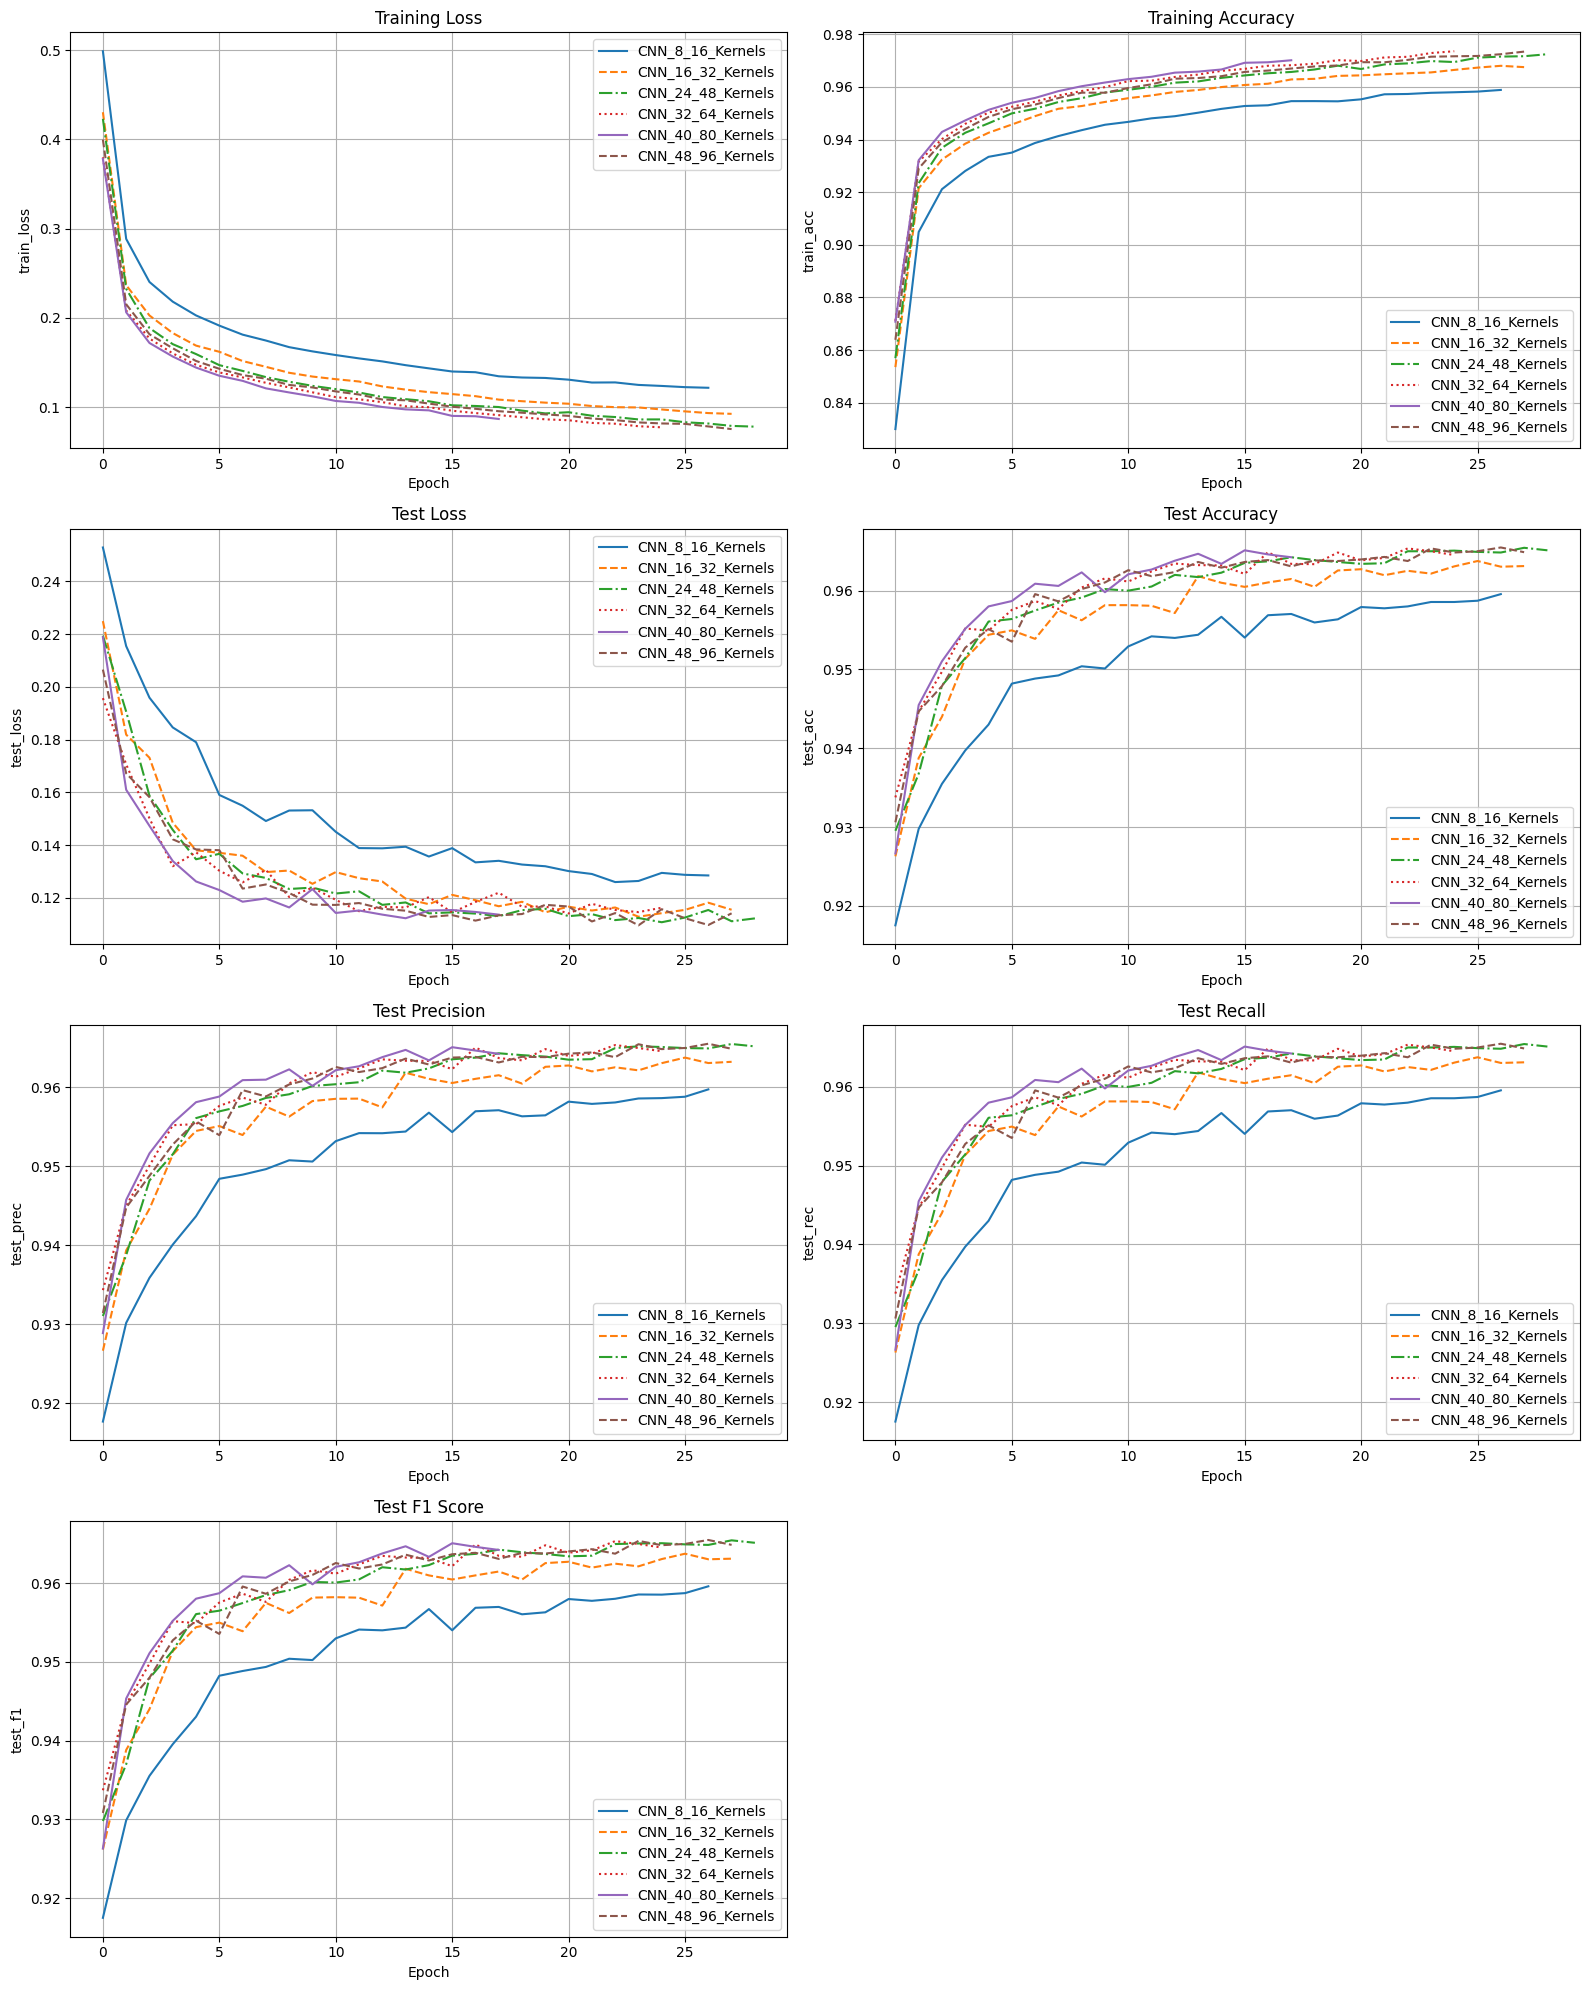

In [10]:
plot_training_history(cnn_num_kernels_models_result)

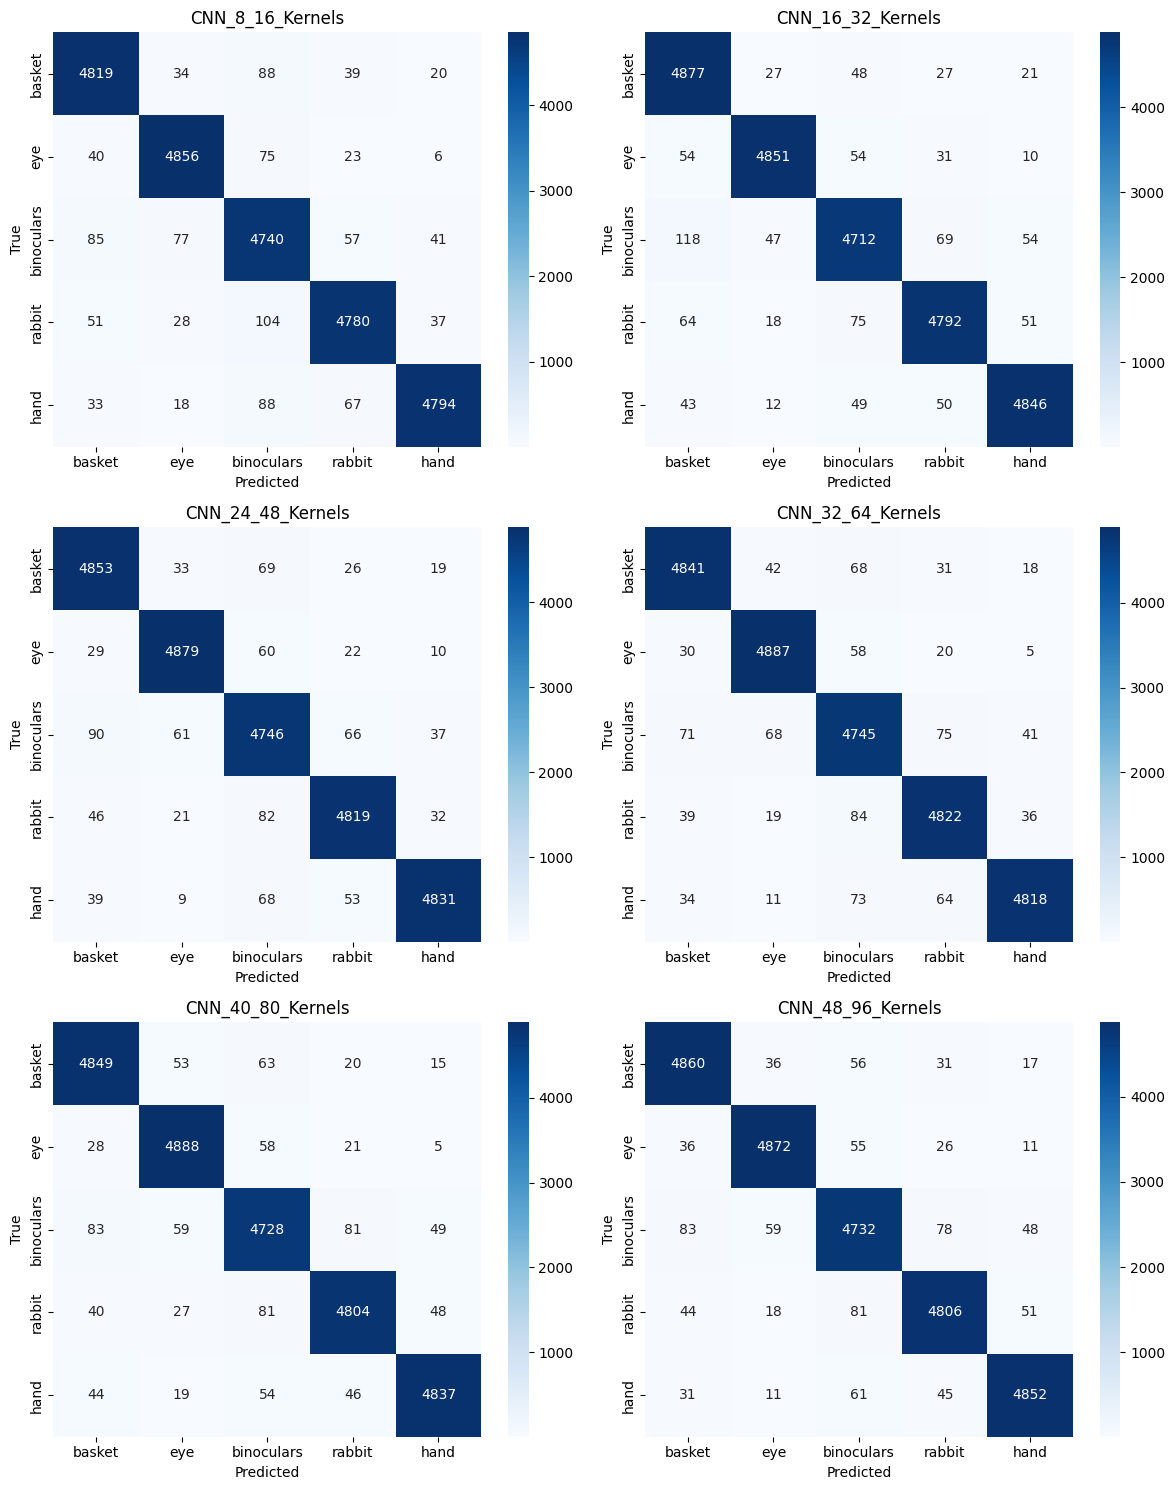

In [11]:
plot_confusion_matrices(cnn_num_kernels_models_result)

##### Results:

You can observe that increasing the number of kernel from 8+16 to 16+32 yields considerable performance improvements. Even using 24+48 kernel helps with the models accuracy. However if you continue to increase the size of the kernels there are not notable gains.

Therefore I will choose to continue with 24+48 kernels

#### Test 3: Amount of dense layers

After this i need to inspect how many dense layers provide the best results

- 1 Dense Layer
- 2 Dense Layers

In [16]:
nets = 2
cnn_num_dense_layer_models = {f'CNN_{n+1}_Dense': BaseModule() for n in range(nets)}

for i, model in enumerate(cnn_num_dense_layer_models.values()):
    model.layers.append(nn.Conv2d(1, 24, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Conv2d(24, 48, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Flatten())
    model.layers.append(nn.Linear(48*7*7, 256))
    model.layers.append(nn.LeakyReLU())

    if i == 1:
        model.layers.append(nn.Linear(256, 128))
        model.layers.append(nn.LeakyReLU())
        model.layers.append(nn.Linear(128, 5))
    else:
        model.layers.append(nn.Linear(256, 5))

    model.to(DEVICE)

print_model_summary(cnn_num_dense_layer_models)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]             624
         LeakyReLU-2           [-1, 24, 28, 28]               0
         MaxPool2d-3           [-1, 24, 14, 14]               0
            Conv2d-4           [-1, 48, 14, 14]          28,848
         LeakyReLU-5           [-1, 48, 14, 14]               0
         MaxPool2d-6             [-1, 48, 7, 7]               0
           Flatten-7                 [-1, 2352]               0
            Linear-8                  [-1, 256]         602,368
         LeakyReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 5]           1,285
Total params: 633,125
Trainable params: 633,125
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.51
Params size (MB): 2.42
Estimated T

In [17]:
cnn_num_dense_layer_models_result = evaluate_models(cnn_num_dense_layer_models)

Start training CNN_1_Dense
Epoch 1 | Learning Rate 0.0010
Train Loss: 0.3969 | Train Acc: 0.8652 | Test Acc: 0.9328 | Test F1: 0.9329
Epoch 2 | Learning Rate 0.0009
Train Loss: 0.2178 | Train Acc: 0.9285 | Test Acc: 0.9444 | Test F1: 0.9443
Epoch 3 | Learning Rate 0.0009
Train Loss: 0.1869 | Train Acc: 0.9380 | Test Acc: 0.9488 | Test F1: 0.9490
Epoch 4 | Learning Rate 0.0009
Train Loss: 0.1711 | Train Acc: 0.9430 | Test Acc: 0.9524 | Test F1: 0.9524
Epoch 5 | Learning Rate 0.0008
Train Loss: 0.1551 | Train Acc: 0.9472 | Test Acc: 0.9554 | Test F1: 0.9555
Epoch 6 | Learning Rate 0.0008
Train Loss: 0.1458 | Train Acc: 0.9503 | Test Acc: 0.9552 | Test F1: 0.9552
Epoch 7 | Learning Rate 0.0007
Train Loss: 0.1387 | Train Acc: 0.9523 | Test Acc: 0.9569 | Test F1: 0.9569
Epoch 8 | Learning Rate 0.0007
Train Loss: 0.1340 | Train Acc: 0.9542 | Test Acc: 0.9582 | Test F1: 0.9583
Epoch 9 | Learning Rate 0.0007
Train Loss: 0.1299 | Train Acc: 0.9561 | Test Acc: 0.9606 | Test F1: 0.9606
Epoch 10 |

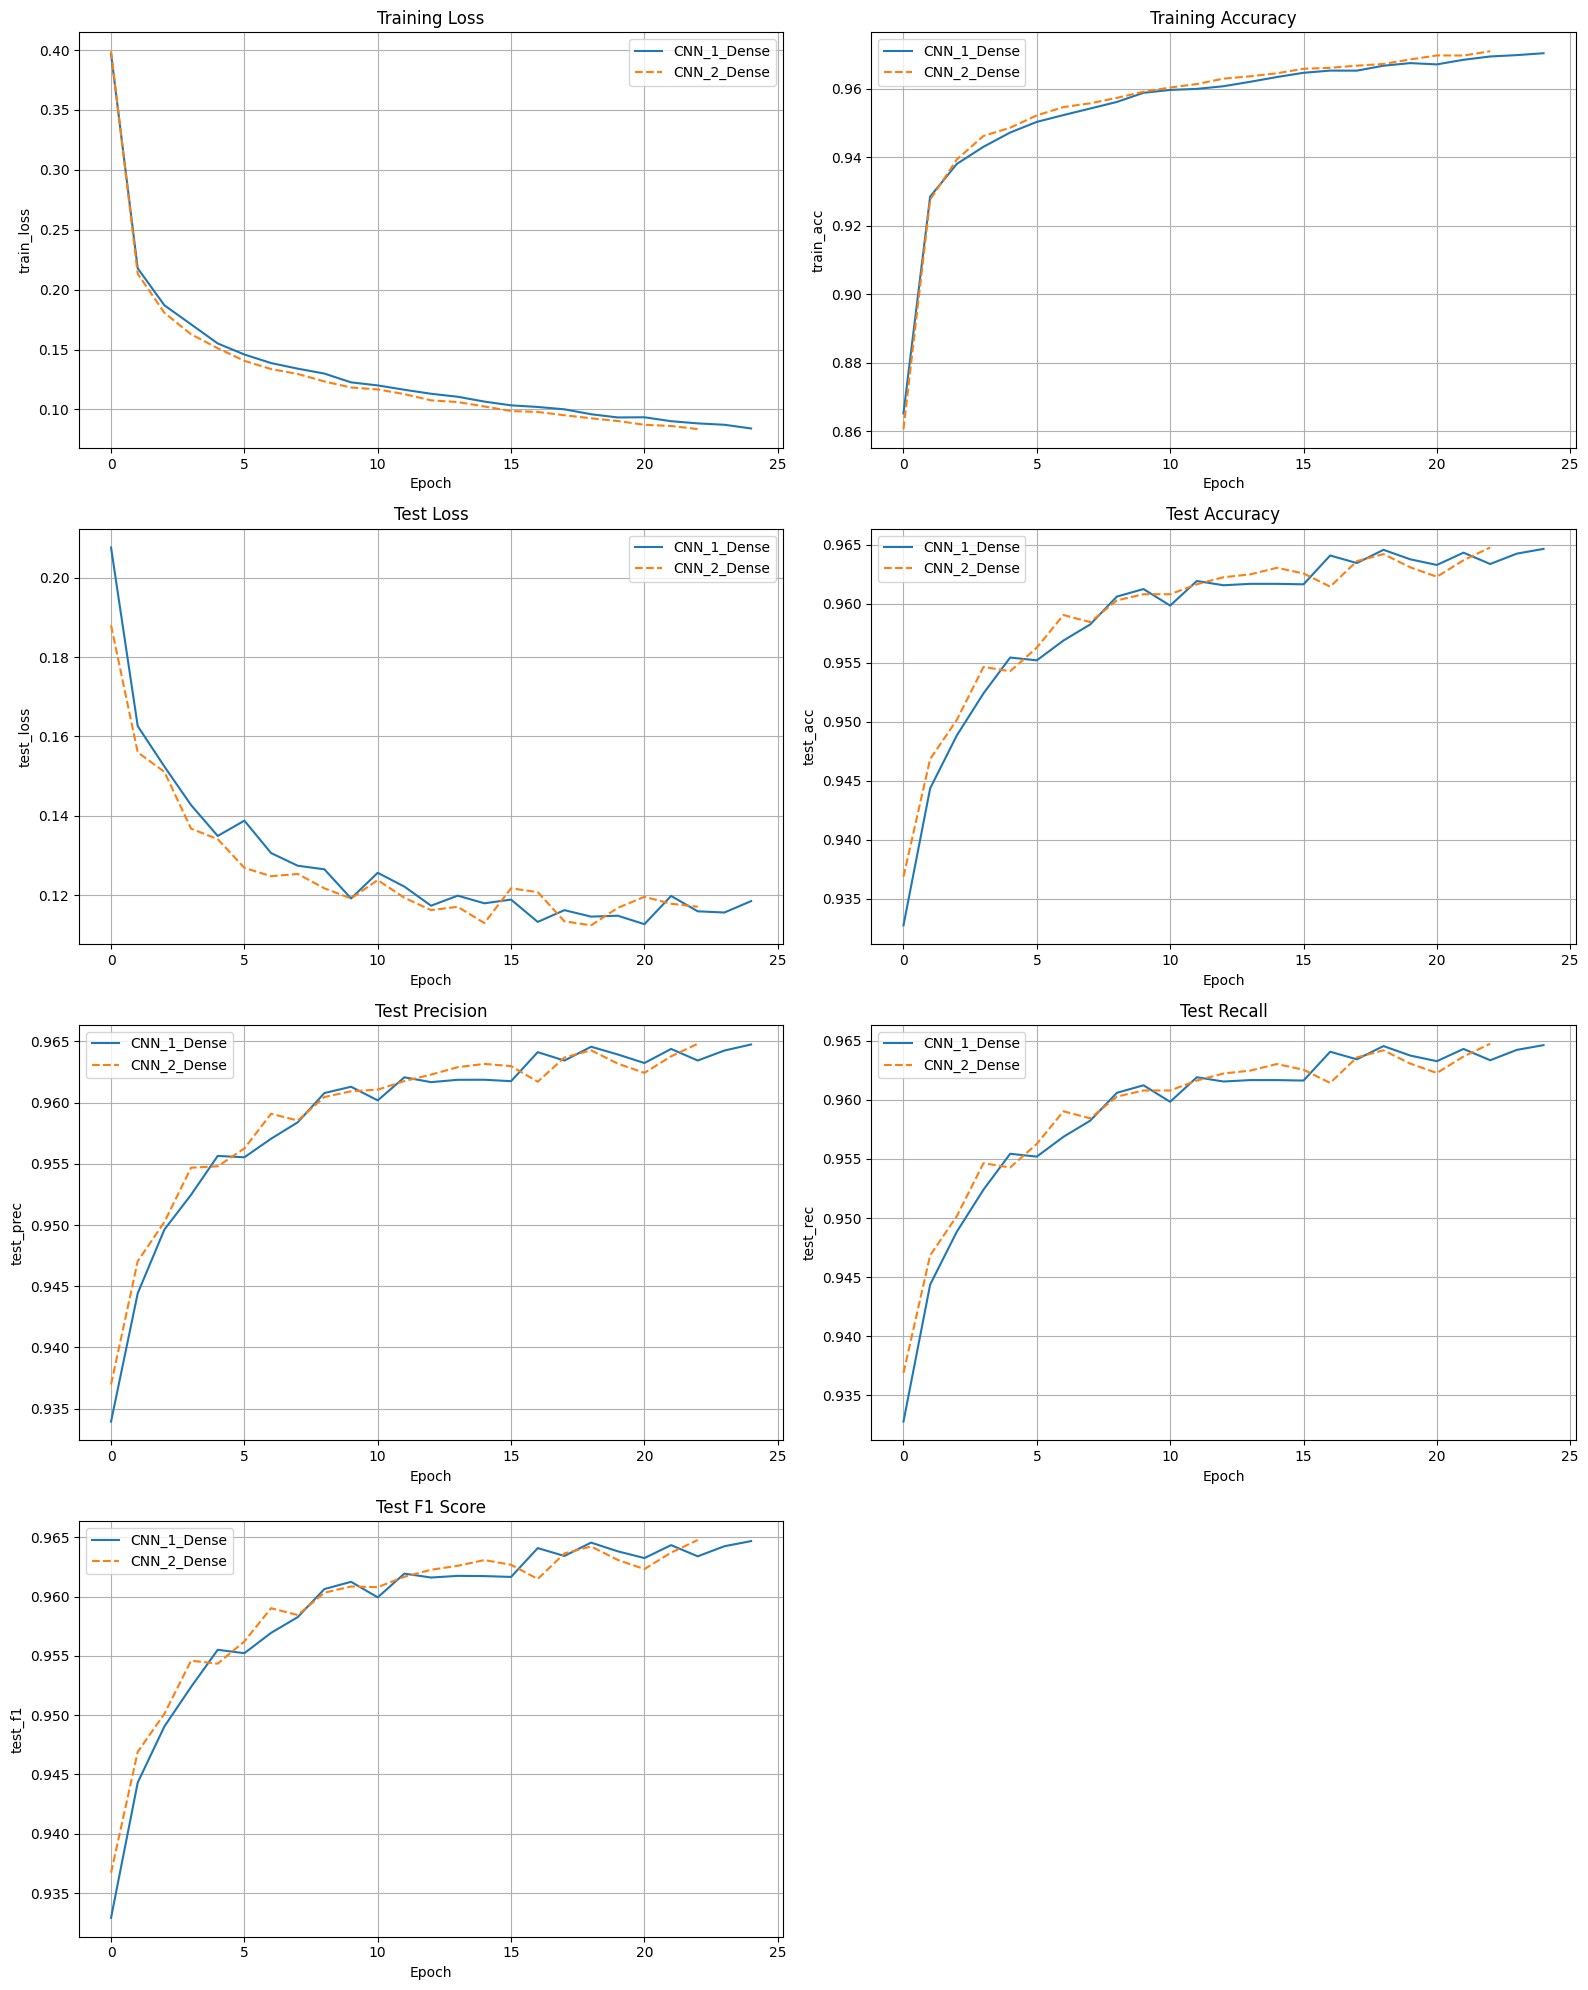

In [18]:
plot_training_history(cnn_num_dense_layer_models_result)

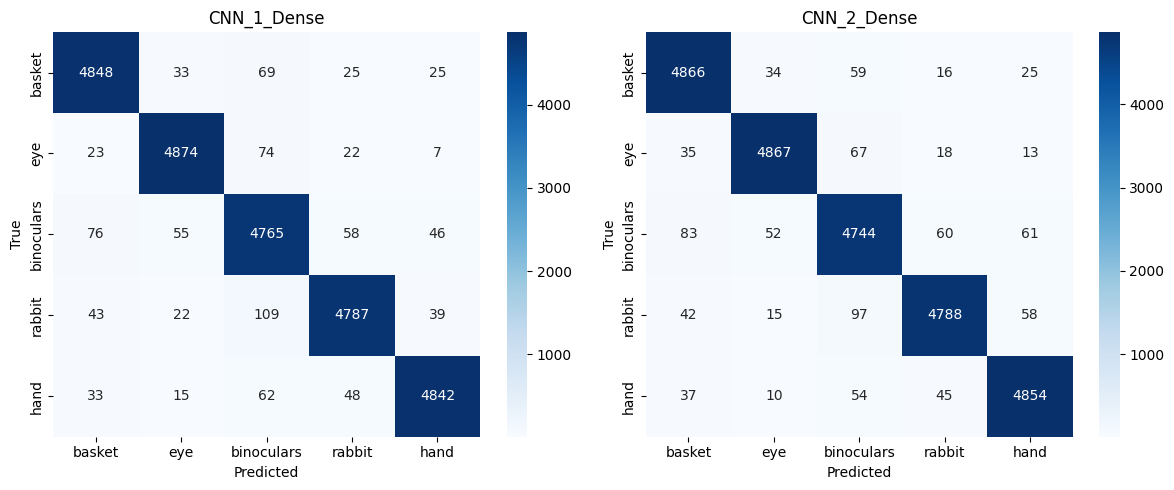

In [19]:
plot_confusion_matrices(cnn_num_dense_layer_models_result)

##### Results:

One can clearly infer that there is no use in adding an additional dense layer to the model.

#### Test 4: How many neurons in my dense layer ?

With this test I want to explore the optimal number of neurons in my dense layer.

- 32 Neurons
- 64 Neurons
- 128 Neurons
- 256 Neurons
- 512 Neurons
- 1024 Neurons

In [6]:
nets = 6
cnn_dense_layer_neuron_models = {f"CNN_{2**(n+5)}_Neurons": BaseModule() for n in range(nets)}

for i, model in enumerate(cnn_dense_layer_neuron_models.values()):
    model.layers.append(nn.Conv2d(1, 24, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Conv2d(24, 48, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Flatten())
    model.layers.append(nn.Linear(48*7*7, 2**(i+5)))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.Linear(2**(i+5), 5))

    model.to(DEVICE)

print_model_summary(cnn_dense_layer_neuron_models)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]             624
         LeakyReLU-2           [-1, 24, 28, 28]               0
         MaxPool2d-3           [-1, 24, 14, 14]               0
            Conv2d-4           [-1, 48, 14, 14]          28,848
         LeakyReLU-5           [-1, 48, 14, 14]               0
         MaxPool2d-6             [-1, 48, 7, 7]               0
           Flatten-7                 [-1, 2352]               0
            Linear-8                   [-1, 32]          75,296
         LeakyReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 5]             165
Total params: 104,933
Trainable params: 104,933
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.50
Params size (MB): 0.40
Estimated T

In [9]:
cnn_dense_layer_neuron_models_result = evaluate_models(cnn_dense_layer_neuron_models)

Start training CNN_32_Neurons
Epoch 1 | Learning Rate 0.0010
Train Loss: 0.4612 | Train Acc: 0.8420 | Test Acc: 0.9196 | Test F1: 0.9195
Epoch 2 | Learning Rate 0.0009
Train Loss: 0.2615 | Train Acc: 0.9139 | Test Acc: 0.9362 | Test F1: 0.9362
Epoch 3 | Learning Rate 0.0009
Train Loss: 0.2189 | Train Acc: 0.9279 | Test Acc: 0.9449 | Test F1: 0.9451
Epoch 4 | Learning Rate 0.0009
Train Loss: 0.1959 | Train Acc: 0.9343 | Test Acc: 0.9453 | Test F1: 0.9451
Epoch 5 | Learning Rate 0.0008
Train Loss: 0.1806 | Train Acc: 0.9402 | Test Acc: 0.9500 | Test F1: 0.9501
Epoch 6 | Learning Rate 0.0008
Train Loss: 0.1694 | Train Acc: 0.9428 | Test Acc: 0.9508 | Test F1: 0.9508
Epoch 7 | Learning Rate 0.0007
Train Loss: 0.1624 | Train Acc: 0.9456 | Test Acc: 0.9516 | Test F1: 0.9515
Epoch 8 | Learning Rate 0.0007
Train Loss: 0.1548 | Train Acc: 0.9479 | Test Acc: 0.9547 | Test F1: 0.9547
Epoch 9 | Learning Rate 0.0007
Train Loss: 0.1472 | Train Acc: 0.9496 | Test Acc: 0.9552 | Test F1: 0.9552
Epoch 1

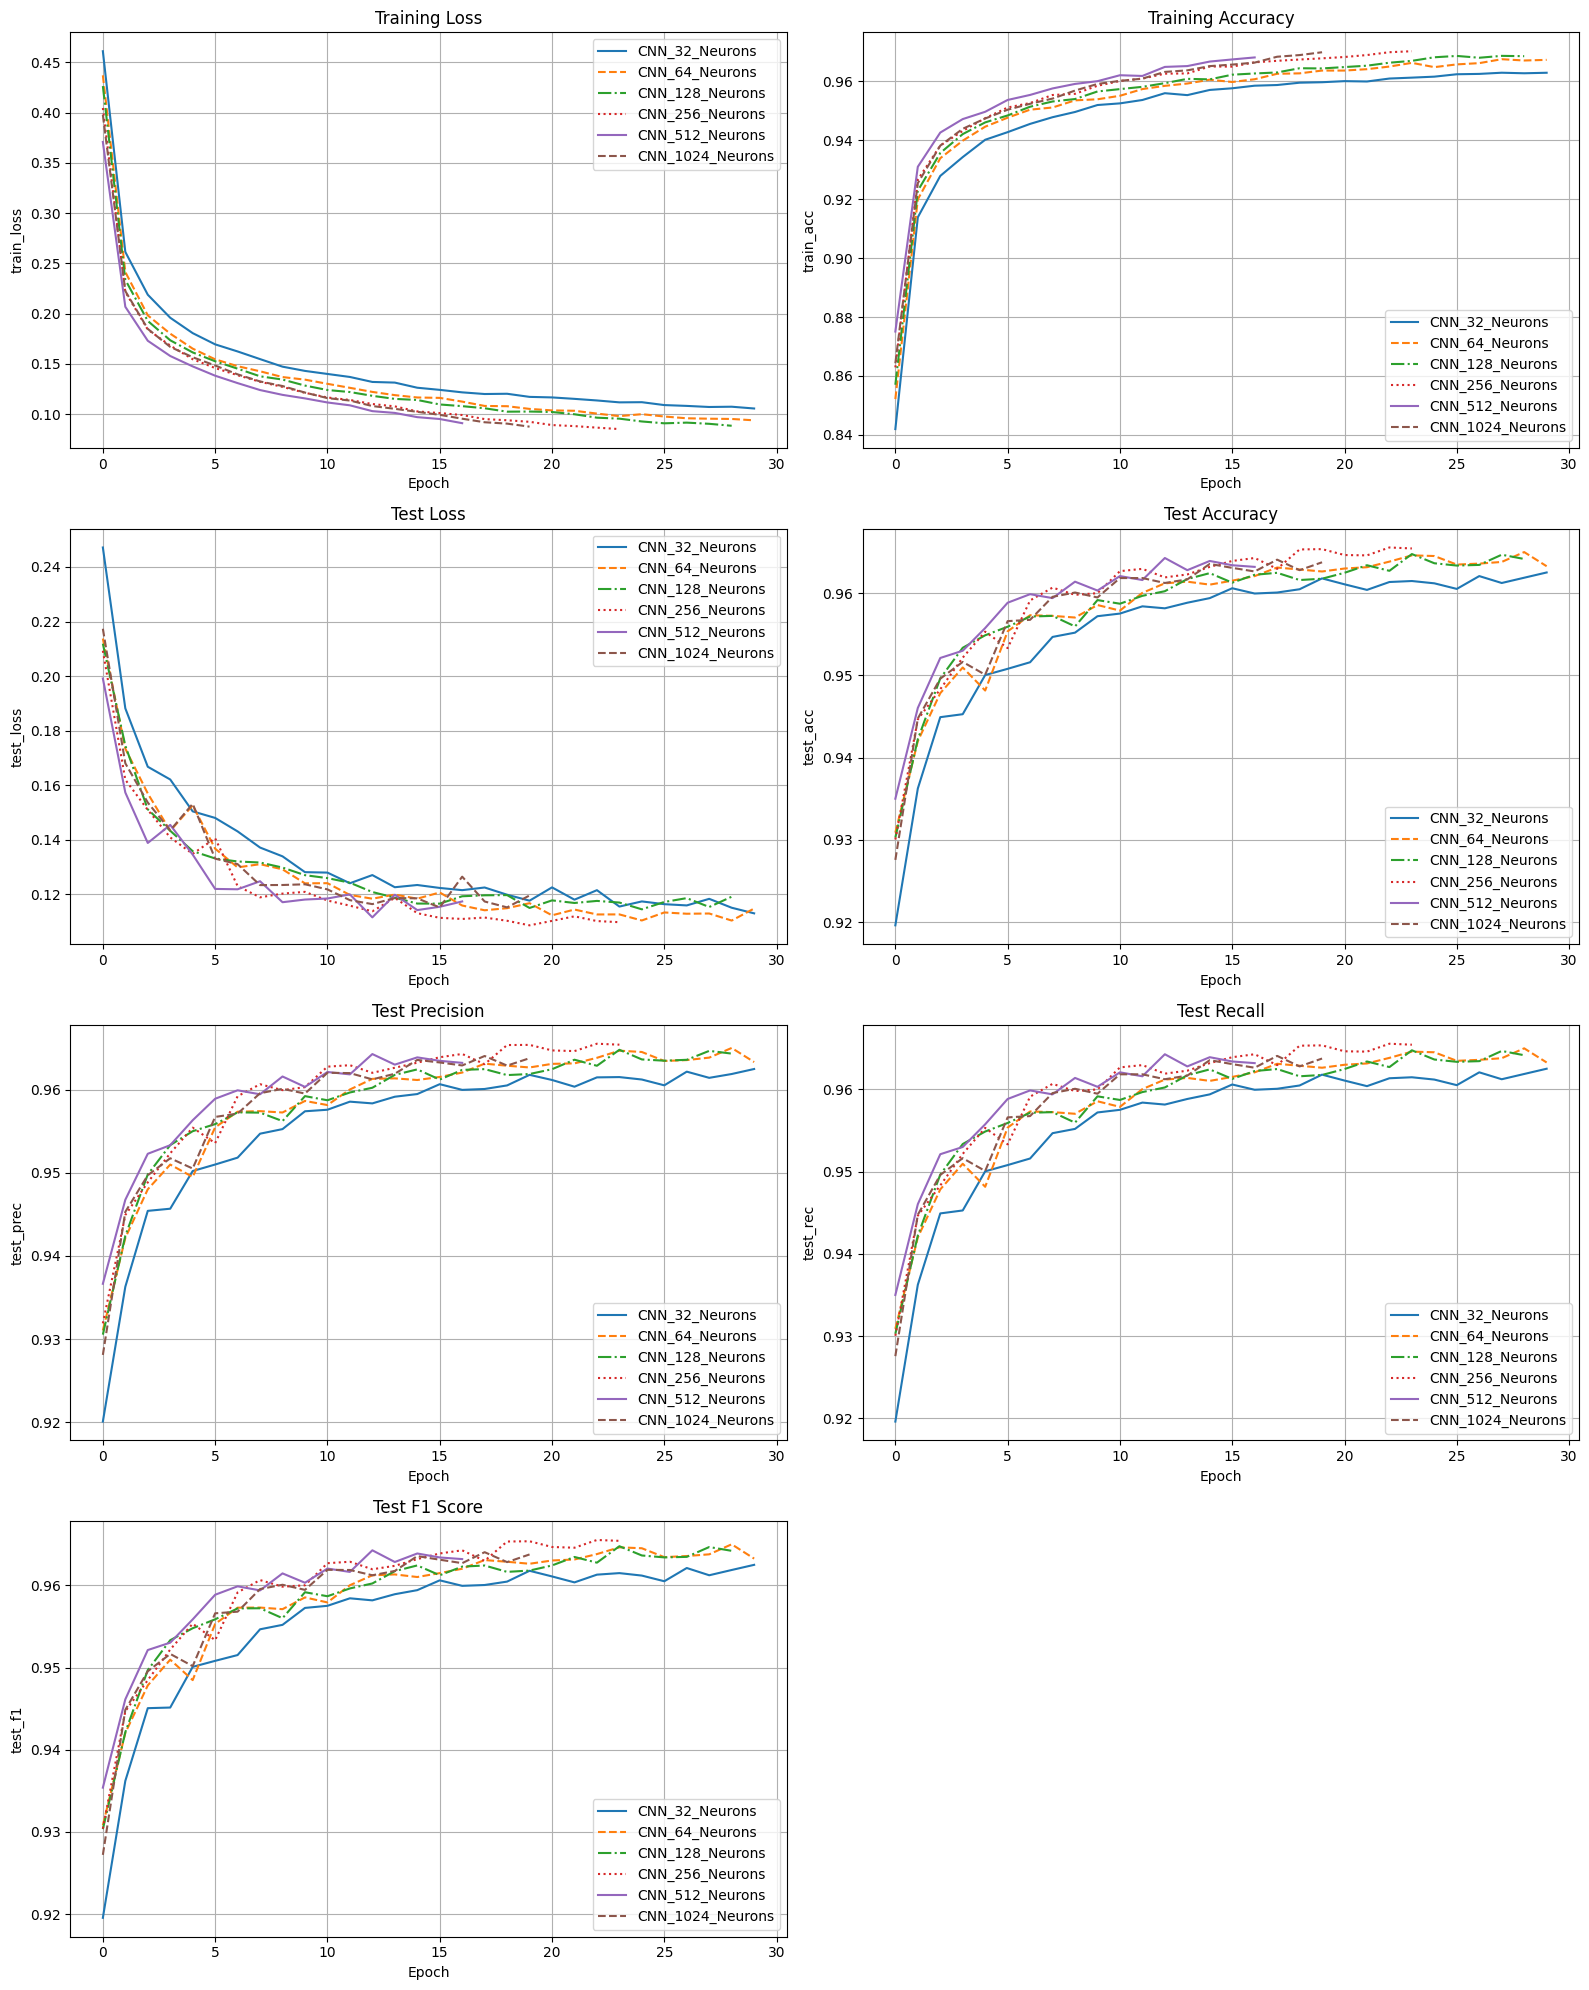

In [10]:
plot_training_history(cnn_dense_layer_neuron_models_result)

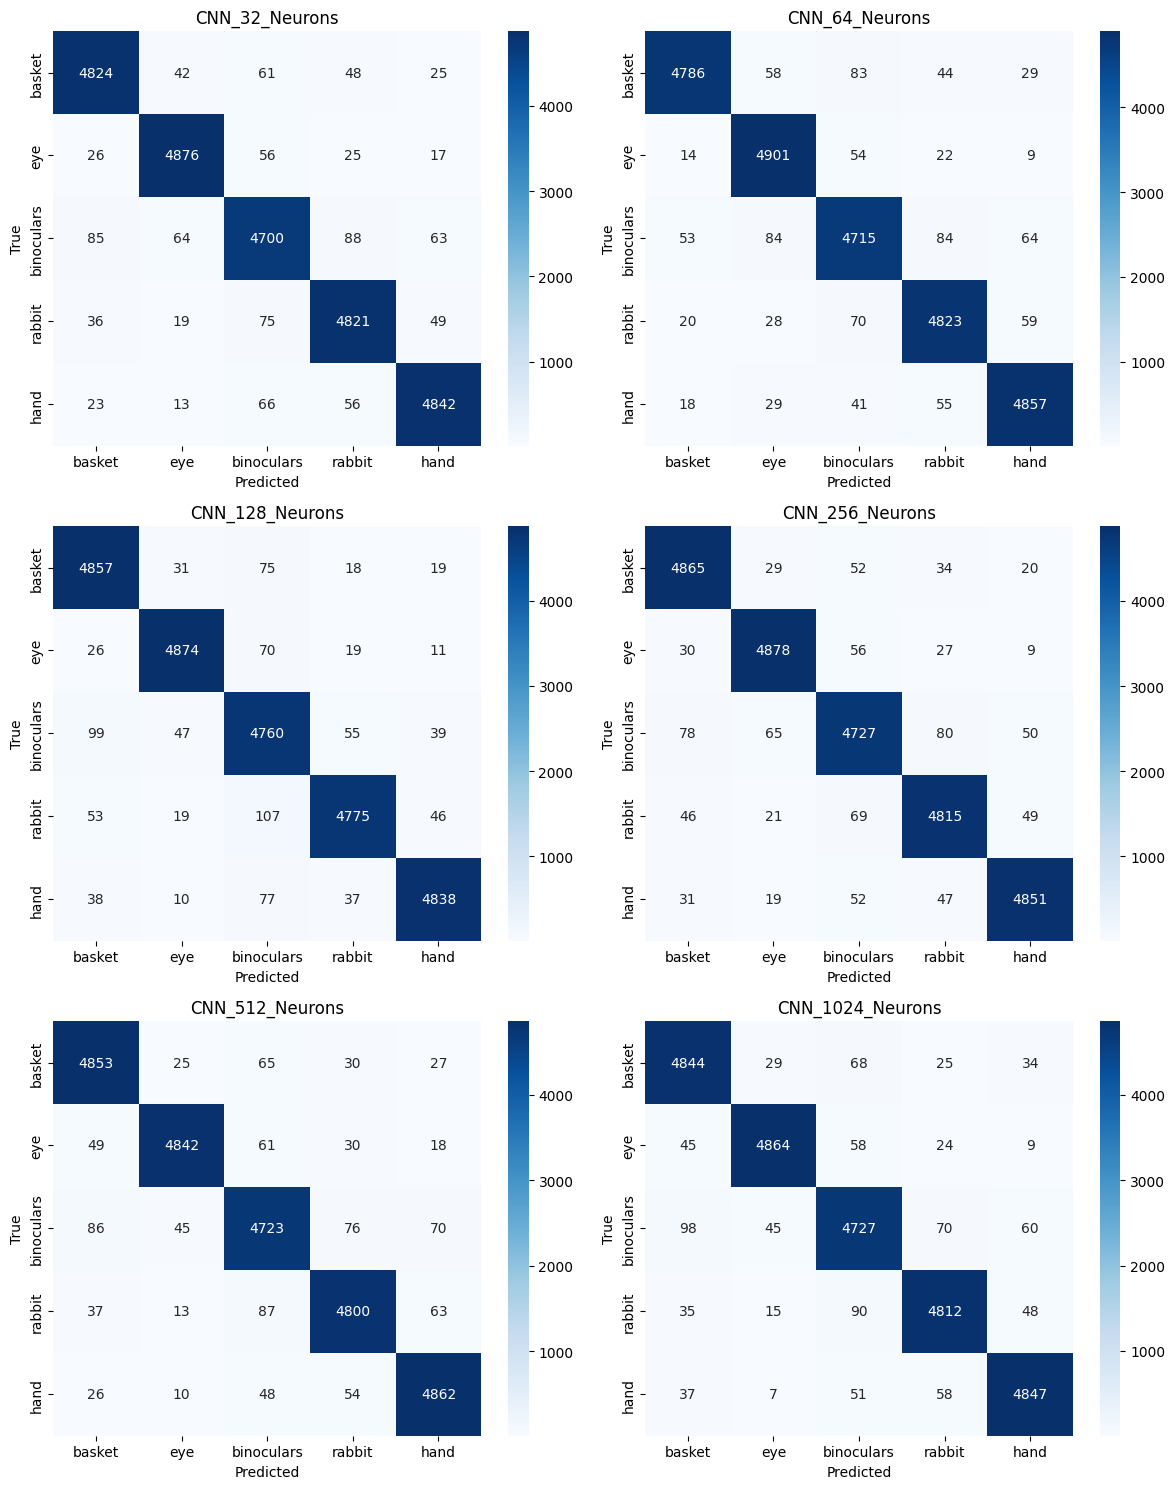

In [13]:
plot_confusion_matrices(cnn_dense_layer_neuron_models_result)

##### Result:


#### Test 5: How much dropout ?

Dropout should be introduced to further optimize model performance

- 0 % - no dropout
- 10 %
- 20 %
- 30 %
- 40 %
- 50 %
- 60 %
- 70 %

In [ ]:
nets = 8
cnn_dropout_models = {f"CNN_{n*0.1:.4f}_Dropout": BaseModule() for n in range(nets)}

for i, model in enumerate(cnn_dropout_models.values()):
    model.layers.append(nn.Conv2d(1, 24, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.Dropout(i*0.1))
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Conv2d(24, 48, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.Dropout(i*0.1))
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Flatten())
    model.layers.append(nn.Linear(48*7*7, 256))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.Dropout(i*0.1))
    model.layers.append(nn.Linear(256, 5))

    model.to(DEVICE)

print_model_summary(cnn_dropout_models)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]             624
         LeakyReLU-2           [-1, 24, 28, 28]               0
           Dropout-3           [-1, 24, 28, 28]               0
         MaxPool2d-4           [-1, 24, 14, 14]               0
            Conv2d-5           [-1, 48, 14, 14]          28,848
         LeakyReLU-6           [-1, 48, 14, 14]               0
           Dropout-7           [-1, 48, 14, 14]               0
         MaxPool2d-8             [-1, 48, 7, 7]               0
           Flatten-9                 [-1, 2352]               0
           Linear-10                  [-1, 256]         602,368
        LeakyReLU-11                  [-1, 256]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                    [-1, 5]           1,285
Total params: 633,125
Trainable params:

In [12]:
cnn_dropout_models_result = evaluate_models(cnn_dropout_models)

Start training CNN_0.0_Dropout
Epoch 1 | Learning Rate 0.0010
Train Loss: 0.3955 | Train Acc: 0.8658 | Test Acc: 0.9254 | Test F1: 0.9250
Epoch 2 | Learning Rate 0.0009
Train Loss: 0.2217 | Train Acc: 0.9265 | Test Acc: 0.9445 | Test F1: 0.9446
Epoch 3 | Learning Rate 0.0009
Train Loss: 0.1855 | Train Acc: 0.9383 | Test Acc: 0.9516 | Test F1: 0.9516
Epoch 4 | Learning Rate 0.0009
Train Loss: 0.1674 | Train Acc: 0.9443 | Test Acc: 0.9547 | Test F1: 0.9547
Epoch 5 | Learning Rate 0.0008
Train Loss: 0.1539 | Train Acc: 0.9477 | Test Acc: 0.9561 | Test F1: 0.9562
Epoch 6 | Learning Rate 0.0008
Train Loss: 0.1454 | Train Acc: 0.9507 | Test Acc: 0.9588 | Test F1: 0.9588
Epoch 7 | Learning Rate 0.0007
Train Loss: 0.1371 | Train Acc: 0.9534 | Test Acc: 0.9576 | Test F1: 0.9576
Epoch 8 | Learning Rate 0.0007
Train Loss: 0.1298 | Train Acc: 0.9558 | Test Acc: 0.9552 | Test F1: 0.9554
Epoch 9 | Learning Rate 0.0007
Train Loss: 0.1273 | Train Acc: 0.9567 | Test Acc: 0.9580 | Test F1: 0.9579
Epoch 

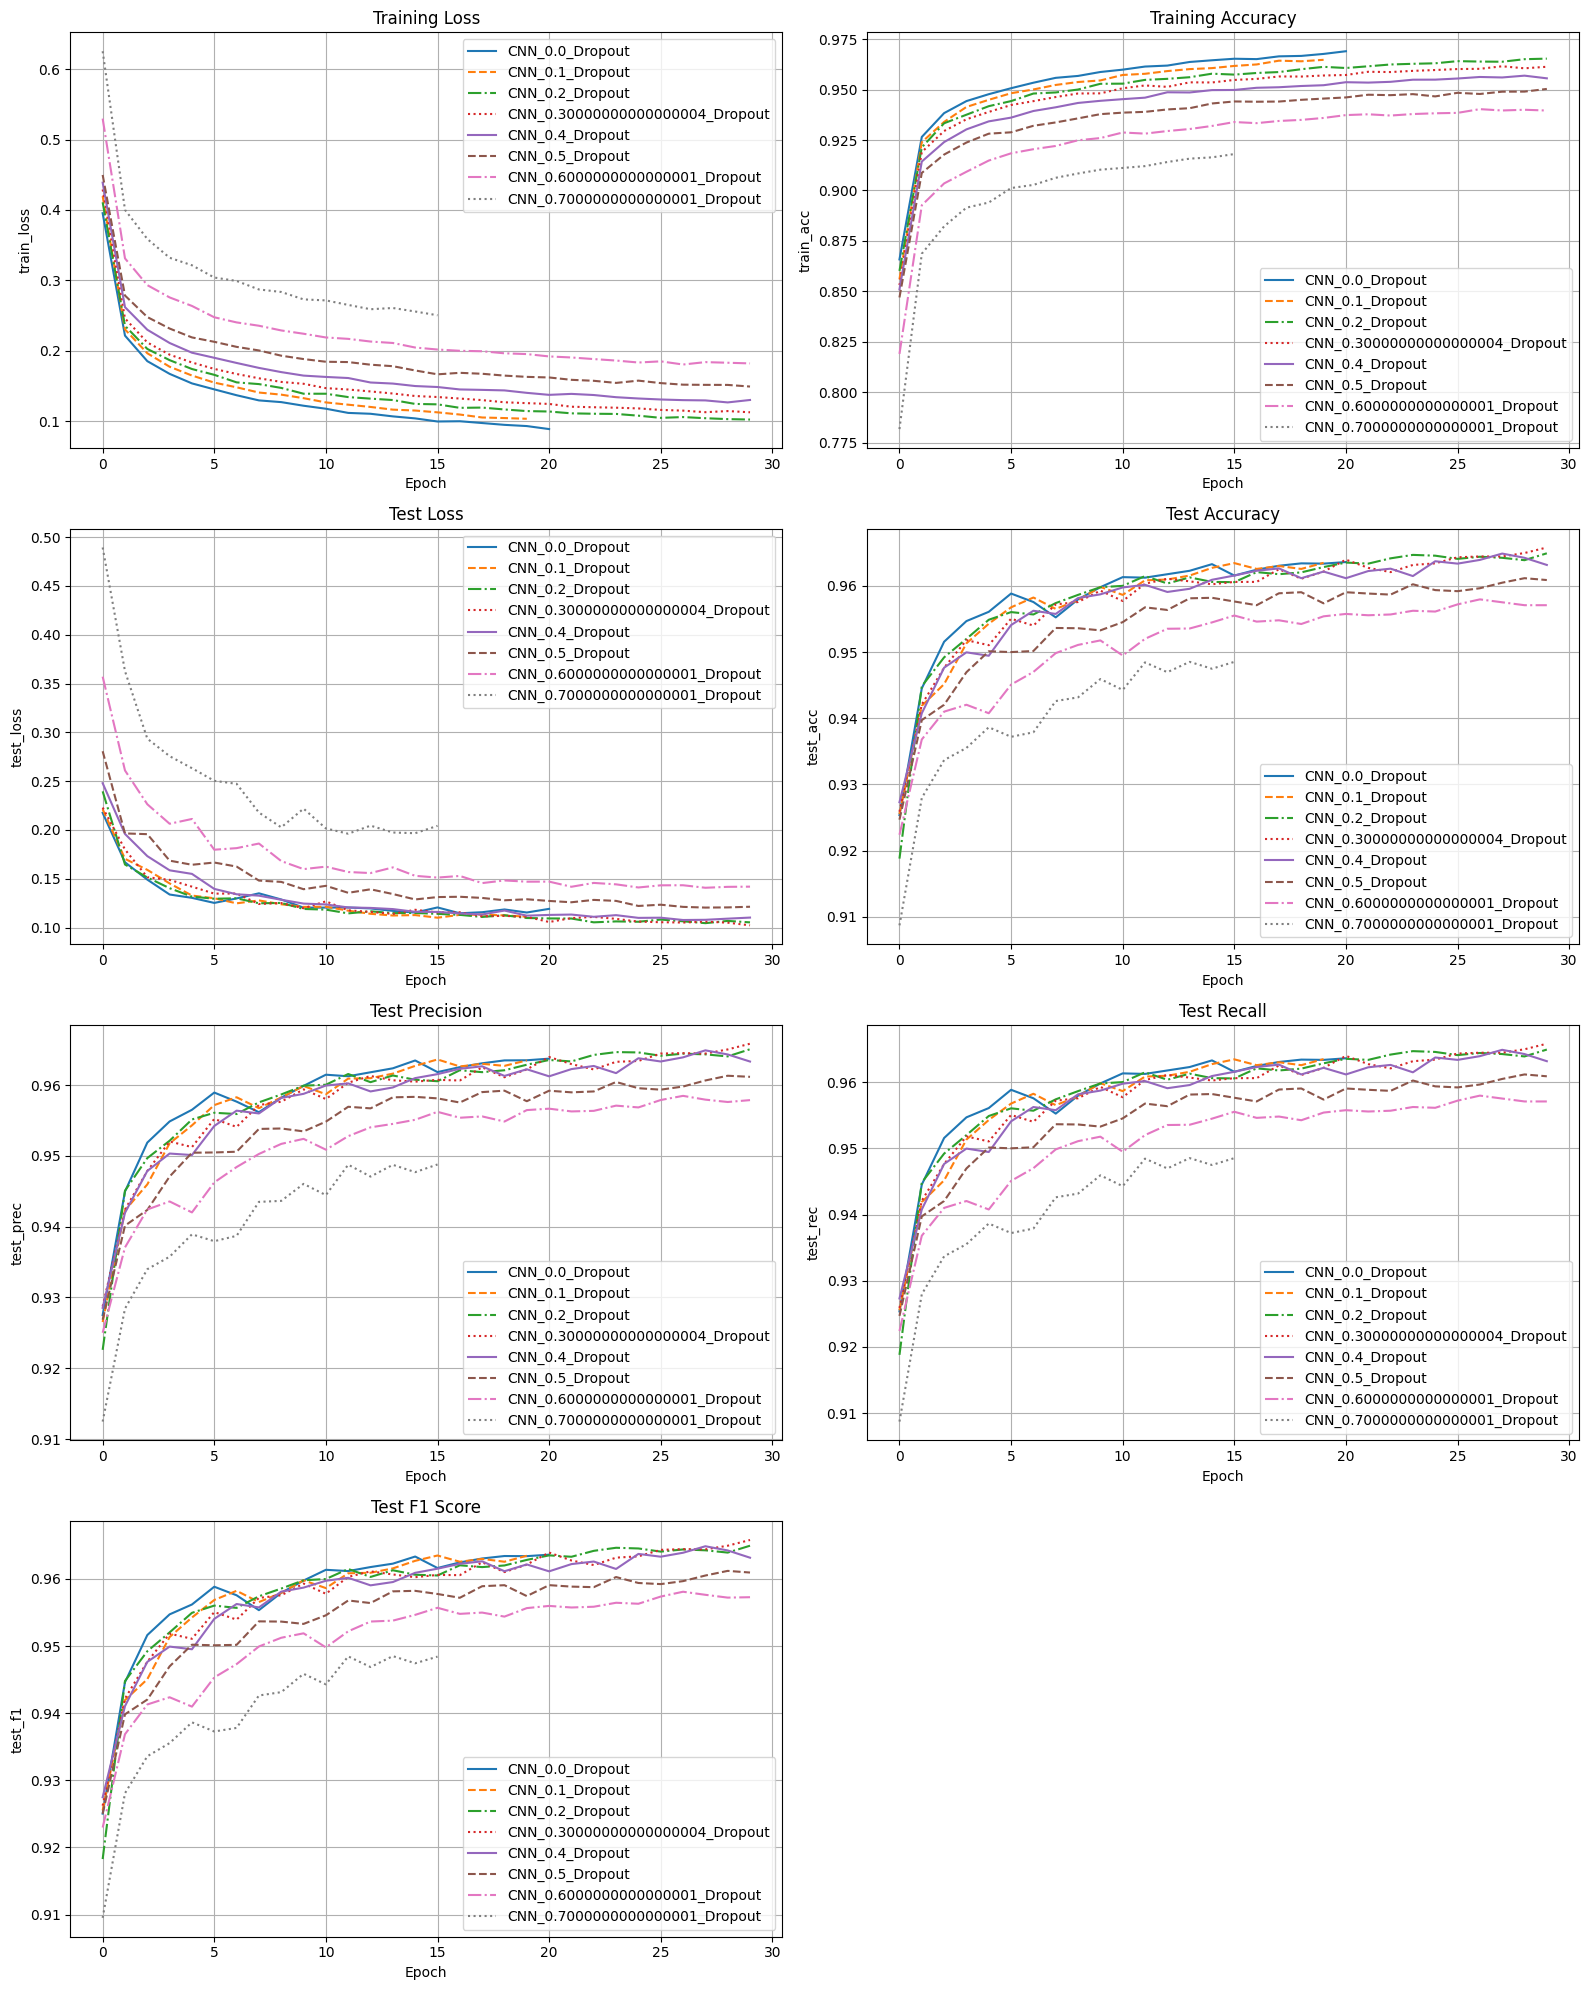

In [14]:
plot_training_history(cnn_dropout_models_result)

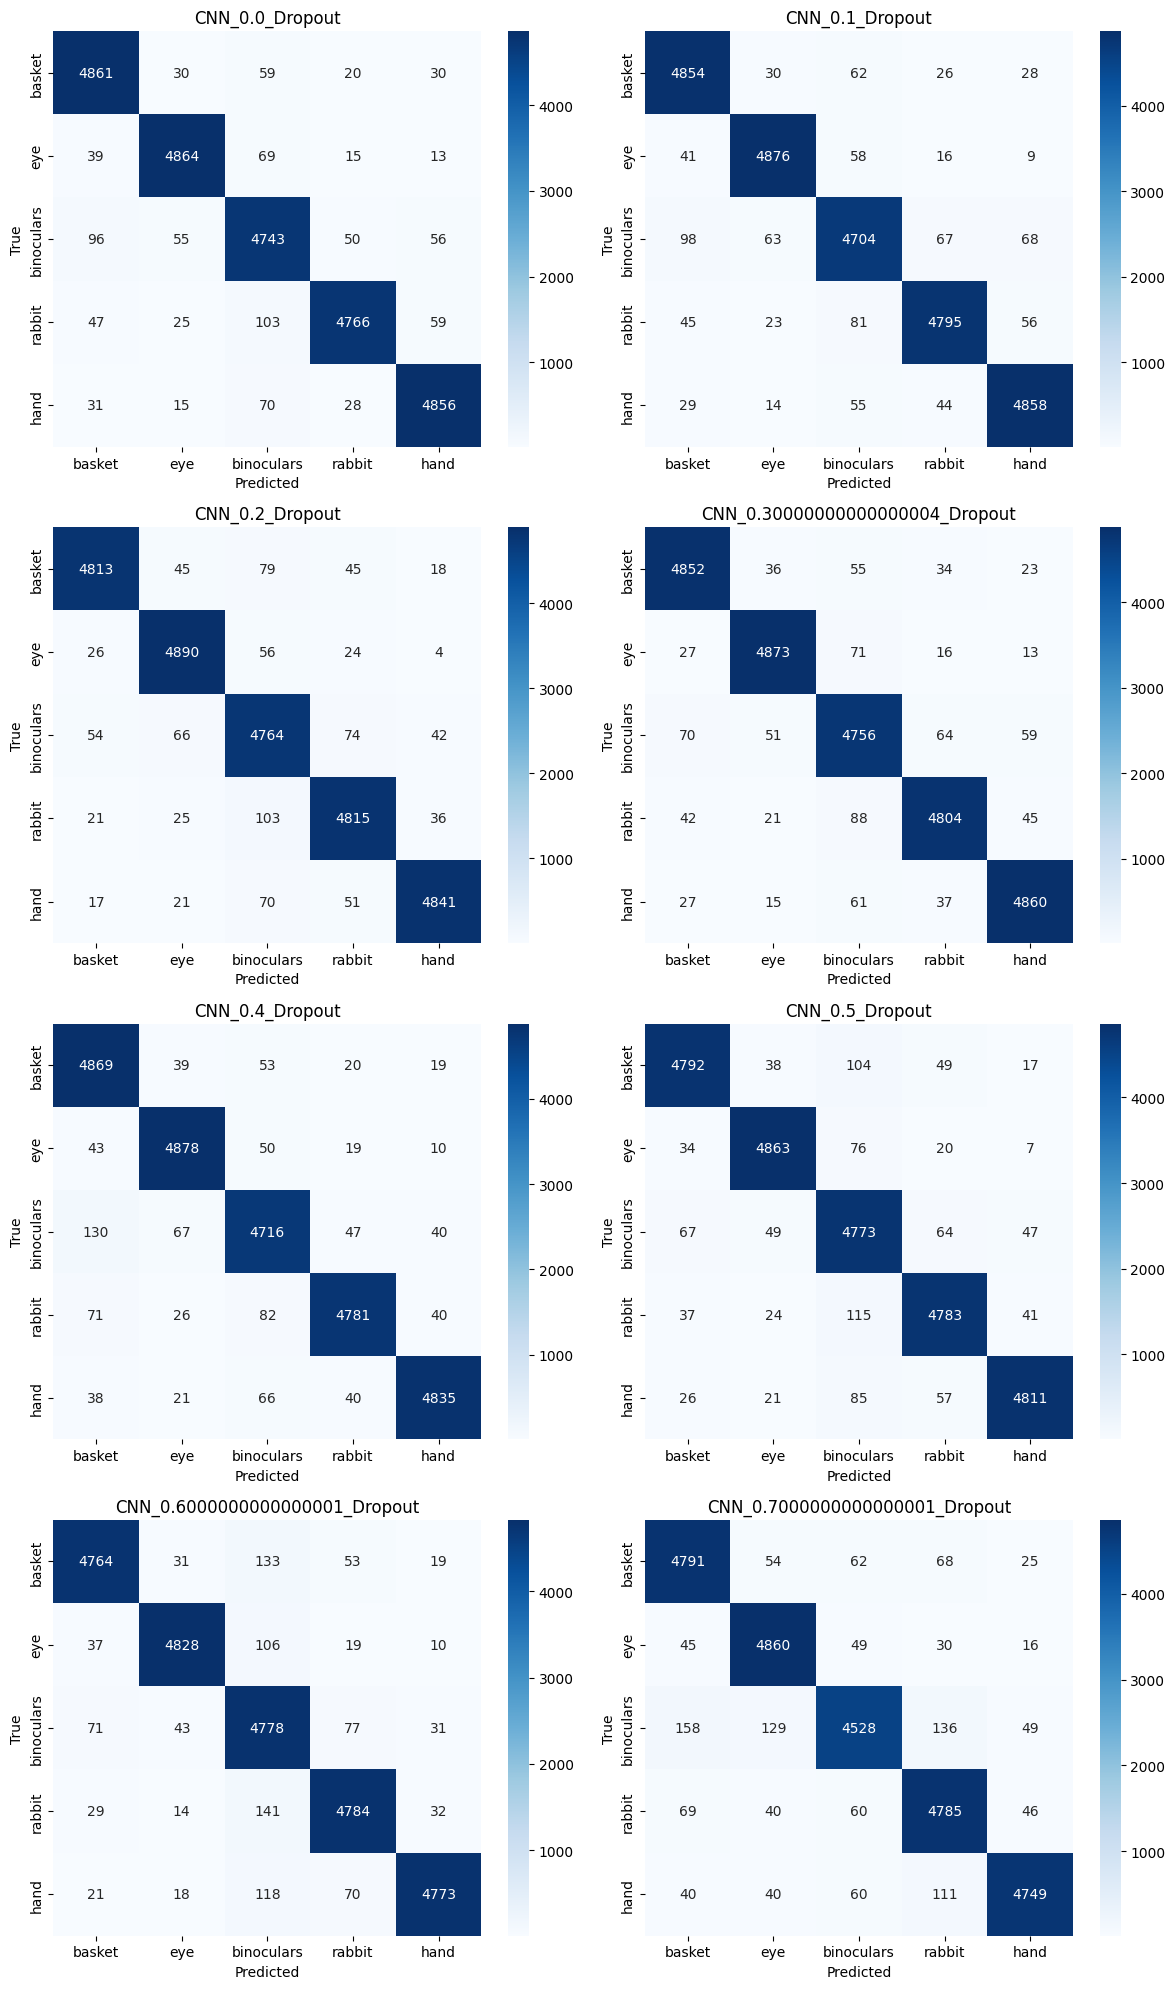

In [15]:
plot_confusion_matrices(cnn_dropout_models_result)

#### Result

Looking at the metrics you can quite clearly determine that the optimal dropout range is from 0.2 - 0.4. So I will equip the model with 0.3 dropout since this performs the best out of the three even though it only marginally better. 

### Test 6: Which activation function ?

During the earlier experiments I used the LeakyReLu activation function opposed to ReLu since I thought cutting of negative values might lose important information. Next I want to test this hypothesis by applying different activation functions to my model:

- ReLu
- LeakyReLu
- Sigmoid
- tanh

In [ ]:

cnn_activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.Sigmoid(), nn.Tanh()]
cnn_activation_function_models = {f"CNN_{str(func.__class__.__name__)}_Activation": BaseModule() for func in cnn_activation_functions}

for i, model in enumerate(cnn_activation_function_models.values()):
    model.layers.append(nn.Conv2d(1, 24, kernel_size=5, padding='same'))
    model.layers.append(cnn_activation_functions[i])
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Conv2d(24, 48, kernel_size=5, padding='same'))
    model.layers.append(cnn_activation_functions[i])
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Flatten())
    model.layers.append(nn.Linear(48*7*7, 256))
    model.layers.append(cnn_activation_functions[i])
    model.layers.append(nn.Linear(256, 5))

    model.to(DEVICE)

print_model_summary(cnn_activation_function_models)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]             624
              ReLU-2           [-1, 24, 28, 28]               0
         MaxPool2d-3           [-1, 24, 14, 14]               0
            Conv2d-4           [-1, 48, 14, 14]          28,848
              ReLU-5           [-1, 48, 14, 14]               0
         MaxPool2d-6             [-1, 48, 7, 7]               0
           Flatten-7                 [-1, 2352]               0
            Linear-8                  [-1, 256]         602,368
              ReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 5]           1,285
Total params: 633,125
Trainable params: 633,125
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.51
Params size (MB): 2.42
Estimated T

In [ ]:
cnn_activation_functions_result = evaluate_models(cnn_activation_function_models)

Start training CNN_ReLU_Activation


KeyboardInterrupt: 

## CNN with Inception Layers

Based on [this](https://arxiv.org/pdf/1409.4842) Paper I want to also test if these inception layers might help. My previous experiments showed that using a very deep model is nit necessary in this case. So in the following I will try to build more shallow model for this particular task instead of using the GoogLeNet itself which features 22 layers.

## Transfer Learning

Next I want to try adapting already pretrained models and compare them to the CNN I constructed.
Since most of the pretrained model were trained of colored images like ImageNet I will choose rather small models

- MobileNetV3 
- 